
<div style="height:40px"><h2 style="align-content:center;padding:10px;color:white;background-color:#A4644E;float:left;margin-top:0px">Experto en Big Data y Data Science</h2>
<h2  style="align-content:center;padding:10px;color:white;background-color:#E0A030;float:left;margin-top:0px;">Análisis de datos y su interpretación</h2></div>


## Conjuntos de clasificadores
En esta práctica vamos a ver el funcionamiento básico de los conjuntos de clasificadores. Haremos algunos ejemplos en problemas en 2D para su visualización y con problemas reales para ver sus capacidades y debilidades. Al final de esta práctica serás capaz de:
<ul>
<li>Describir el proceso de combinación de clasificadores base en conjuntos y cómo se modifican las fronteras de decisión </li>
<li>Medir tiempos de entrenamiento y de clasificación en  conjuntos de clasificadores y ver cómo varía con respecto a la creación de un único árbol</li>
<li>Obtener el error de generalización de conjuntos de clasificadores en conjuntos de datos reales</li>
<li>Analizar la importancia de las variables de entrenamiento en el modelo.</li>
</ul>
<p>Todas las cuestiones se contestarán en este notebook directamente, que es lo que deberéis entregar.
Las cuestiones a responder están marcadas con fondo verde y vuestras respuestas deben ir en los cuadros en amarillo.</p> 



In [1]:
# Hacemos los imports necesarios
%matplotlib inline
import numpy as np
from sklearn.datasets import load_iris
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
import numpy.matlib as matl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import scipy as sp


### Teorema de Condorcet 

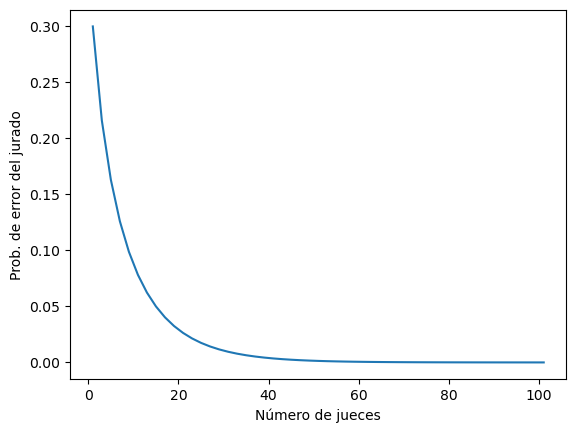

In [2]:
prob_error = 0.3  # <-- Modifica esta probabilidad para ver cómo evoluciona 
                  #     la probabilidad de equivocarse del jurado
num_jueces = 101   # Mejor que sea impar para evitar empates

p_error_jurado = np.zeros(num_jueces)
for i in range(1,num_jueces+1,2):
    mayoria = 1 + i//2
    p_error_jurado[i-1] = np.sum(sp.stats.binom.pmf(range(mayoria,i+1), i, prob_error))

# Puedes cambiar a semilogy para ver mejor cómo baja la prob de error
plt.plot(range(1,num_jueces+1,2),p_error_jurado[::2])
plt.ylabel('Prob. de error del jurado')
_ = plt.xlabel('Número de jueces')

# Algunas cuestiones:
#   * ¿Cuántos jueces necesitas para estar tener una prob del 99%
#      de que el jurado acierte con prob_error=0.3? ¿y con prob_error=0.1? 
#      ¿y con 0.45?
#   * ¿Qué sucede si la probabilidad de equivocarse de cada juez es >0.5?


### 1.- Conjuntos de datos en 2D para el anáilisis visual de las fronteras de decisión y cómo cambian con algunos parámetros

##### Funciones auxiliares
Antes definiremos algunas funciones (autores Luis Lago y Manuel Sanchez Montañes) que usaremos a lo largo de la práctica. La primera, *createDataSet*, es para crear los problemas, siempre con dos clases y en dos dimensiones. Sus argumentos son:

- *n*, número de patrones en el problema

- *model*, tipo de modelo para la frontera que separa las clases, puede ser 'linear', 'square' o 'sine'

- *ymargin*, margen de separación entre las dos clases, cuanto mayor es *ymargin* más separadas están las clases, valores negativos implican solape entre las clases

- *noise*, introduce un ruido gausiano a la x e y

- *output_boundary*, Si vale True la función devuelve la frontera de decisión

In [3]:
def createDataSet(n,model,ymargin,noise=None,output_boundary=False):
    x = np.random.rand(n,1)*2.0*np.pi
    xbnd = np.linspace(0,2.0*np.pi,100)

    if model == 'sine':
        y = (np.random.rand(n,1) - 0.5)*2.2
        c = y > np.sin(x)
        ybnd = np.sin(xbnd)
    elif model == 'linear':
        y = np.random.rand(n,1)*2.0*np.pi
        c = y > x
        ybnd = xbnd
    elif model == 'square':
        y = np.random.rand(n,1)*4.0*np.pi*np.pi
        c = y > x*x
        ybnd = xbnd*xbnd
    else:
        y = np.random.rand(n,1)*2.0*np.pi
        c = y > x
        ybnd = xbnd
    
    y[c == True] = y[c == True] + ymargin
    y[c == False] = y[c == False] - ymargin
    
    if noise is not None:
        y = y + noise * np.random.randn(n,1)
        x = x + noise * np.random.randn(n,1)

    if output_boundary == True:
        return x, y, c, xbnd, ybnd
    else:
        return x, y, c
    

La función *plotModel* la usaremos para dibujar el resultado de un clasificador sobre el conjunto de datos. Sus argumentos son:

- *x*, coordenada x de los puntos

- *y*, coordenada y de los puntos

- *c*, clase de los puntos, si se pasa None, entonces considera que x e y son la frontera real de decisión y la muestra con plot

- *clf*, el clasificador

- *title*, título para el gráfico

In [4]:
def plotModel(x,y,clase,clf,title):
    x_min, x_max = x.min() - .2, x.max() + .2
    y_min, y_max = y.min() - .2, y.max() + .2
    hx = (x_max - x_min)/100.
    hy = (y_max - y_min)/100.
    xx, yy = np.meshgrid(np.arange(x_min, x_max, hx), np.arange(y_min, y_max, hy))

    if hasattr(clf, "decision_function"):
        z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    else:
        z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

    z = z.reshape(xx.shape)
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    #ax = plt.subplot(1, 1, 1)
    plt.contourf(xx, yy, z, cmap=cm, alpha=.8)
    plt.contour(xx, yy, z, [0.5], linewidths=[2], colors=['k'])

    if clase is not None:
        plt.scatter([x[clase==0]], [y[clase==0]], c='#FF0000')
        plt.scatter([x[clase==1]], [y[clase==1]], c='#0000FF')
    else:
        plt.plot(x,y,'g', linewidth=3)
        
    plt.gca().set_xlim(xx.min(), xx.max())
    plt.gca().set_ylim(yy.min(), yy.max())
    plt.grid(True)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title(title)

La función, *plotData*, la usaremos para dibujar los datos. Sus argumentos son:

- *x*, coordenada x de los puntos

- *y*, coordenada y de los puntos

- *c*, clase de los puntos

- *style0*, estilo con el que pintamos los puntos de la clase 0

- *style1*, estilo con el que pintamos los puntos de la clase 1

- *title*, título para el gráfico

In [5]:
def plotData(x,y,c,style0,style1,title):
    plt.plot(x[c==0],y[c==0],style0)
    plt.plot(x[c==1],y[c==1],style1)
    plt.grid(True)
    plt.axis([x.min()-0.2, x.max()+0.2, y.min()-0.2, y.max()+0.2])
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title(title)

#### Visualizar el conjunto
Se entrena un random forest con 3 árboles para visualizar la frontera de decisión cuándo se combinan en el conjunto de clasificadores y cada árbol por separado
<div style="background-color:#AAEEAA;padding:20px;border:solid;">Ejecuta el código de con noise=0 y n_estimators=3 y estudia el resultado de los árboles por separado y en conjunto. En concreto analiza:
<ul>
<li> (1) Las fronteras de decisión de los árboles individuales con respecto a la frontera de los árboles combinados.</li>
<li> (2) ¿Por qué son tan diferentes las fronteras de los árboles individuales? Para responder piensa cómo se han creado esos árboles</li>
<li> (3) Mira los errores en test de los árboles individuales y del conjunto ¿Cuál es que mejor error obtine? ¿Por qué?</li>
</ul>
</div>
</div>
<br/>
<div style="background-color:#EEEEAA;padding:20px;border:solid;">Respuestas:
<ul>

<li> (1) : Los Random Forests ayudan a clasificar mejor que un solo árbol de decisión porque combinan varios árboles con estructuras diferentes. Varios árboles trabajando juntos generalmente conducen a mejores resultados en datos de prueba. Random Forests también pueden indicar qué características son más importantes para la clasificación. 

- **Árboles Individuales (Arbol 1, Arbol 2, Arbol 3):** Cada árbol tiene sus propias líneas dentro de su sección designada del gráfico. Estas líneas muestran cómo ese árbol en particular clasifica los puntos de datos. 

- **La Frontera de Los Arboles Combinados (Conjunto combinado):** También hay una línea única y más suave que abarca todos los puntos de datos. Esta línea representa la frontera de decisión final para todo el modelo Random Forest, combinando las predicciones de los tres árboles. 


</li>

<li> (2) :

- Los Random Forests introducen aleatoriedad durante el entrenamiento. Cada árbol se construye con un subconjunto aleatorio de características del total. Esto significa que cada árbol lleva a fronteras de decisión distintos.

- En cada nodo de un árbol de decisión, los datos se dividen según el valor de una característica elegida aleatoriamente de un subconjunto de divisiones posibles. Esto puede generar divisiones ligeramente diferentes en cada árbol, incluso para la misma característica.

</li>

<li> (3) : 

**Menor Error con el Conjunto:** El conjunto combinado (todos los árboles juntos) tendrá un error de prueba menor que el de los árboles individuales.

Al combinar las predicciones de múltiples árboles con sesgos ligeramente diferentes, el modelo final se vuelve más robusto al ruido y menos propenso al sobreajuste.

Si todos los árboles fueran iguales, cometerían los mismos errores. Al combinarlos, el bosque aleatorio se vuelve más adaptable a nuevos datos no vistos durante el entrenamiento.

</li>
</ul>
</div>

<div style="background-color:#AAEEAA;padding:20px;border:solid;">Ahora ejecuta las dos celdas siguientes modificando el nivel de ruiso (noise=0.0 y noise=0.3). A continuación prueba con n_estimators igual a 3, 31 y 301 para cada uno de los niveles de ruido y rellena el acierto en test y train en la siguiente tabla:<br/></div>
<br>

<div style="background-color:#EEEEAA;padding:20px;border:solid;">

(4) Respuestas:

| Acierto train/test | n_estimators=3                                 | n_estimators=31                                | n_estimators=301                               |
|--------------------|------------------------------------------------|------------------------------------------------|------------------------------------------------|
| noise=0            | Score train = 0.993333 / Score test = 0.944667 | Score train = 1.000000 / Score test = 0.954333 | Score train = 1.000000 / Score test = 0.953000 |
| noise=0,3          | Score train = 0.966667 / Score test = 0.827667 | Score train = 1.000000 / Score test = 0.847333 | Score train = 1.000000 / Score test = 0.851000 | 

</div>

In [6]:
# Problem data:
np.random.seed(11)
n = 300
model = 'sine'
ymargin = 0.
noise = 0.0                  # <========= Modifica este valor 0 ó 0.3, (antes responde a las cuestiones de arriba)
x, y, clase, xbnd, ybnd = createDataSet(n, model, ymargin, noise, True)
xtest, ytest, clasetest = createDataSet(n*10, model, ymargin, noise)


Score train = 0.993333
Score test = 0.944667
Score test tres primeros árboles = 0.908000,0.930333,0.890667


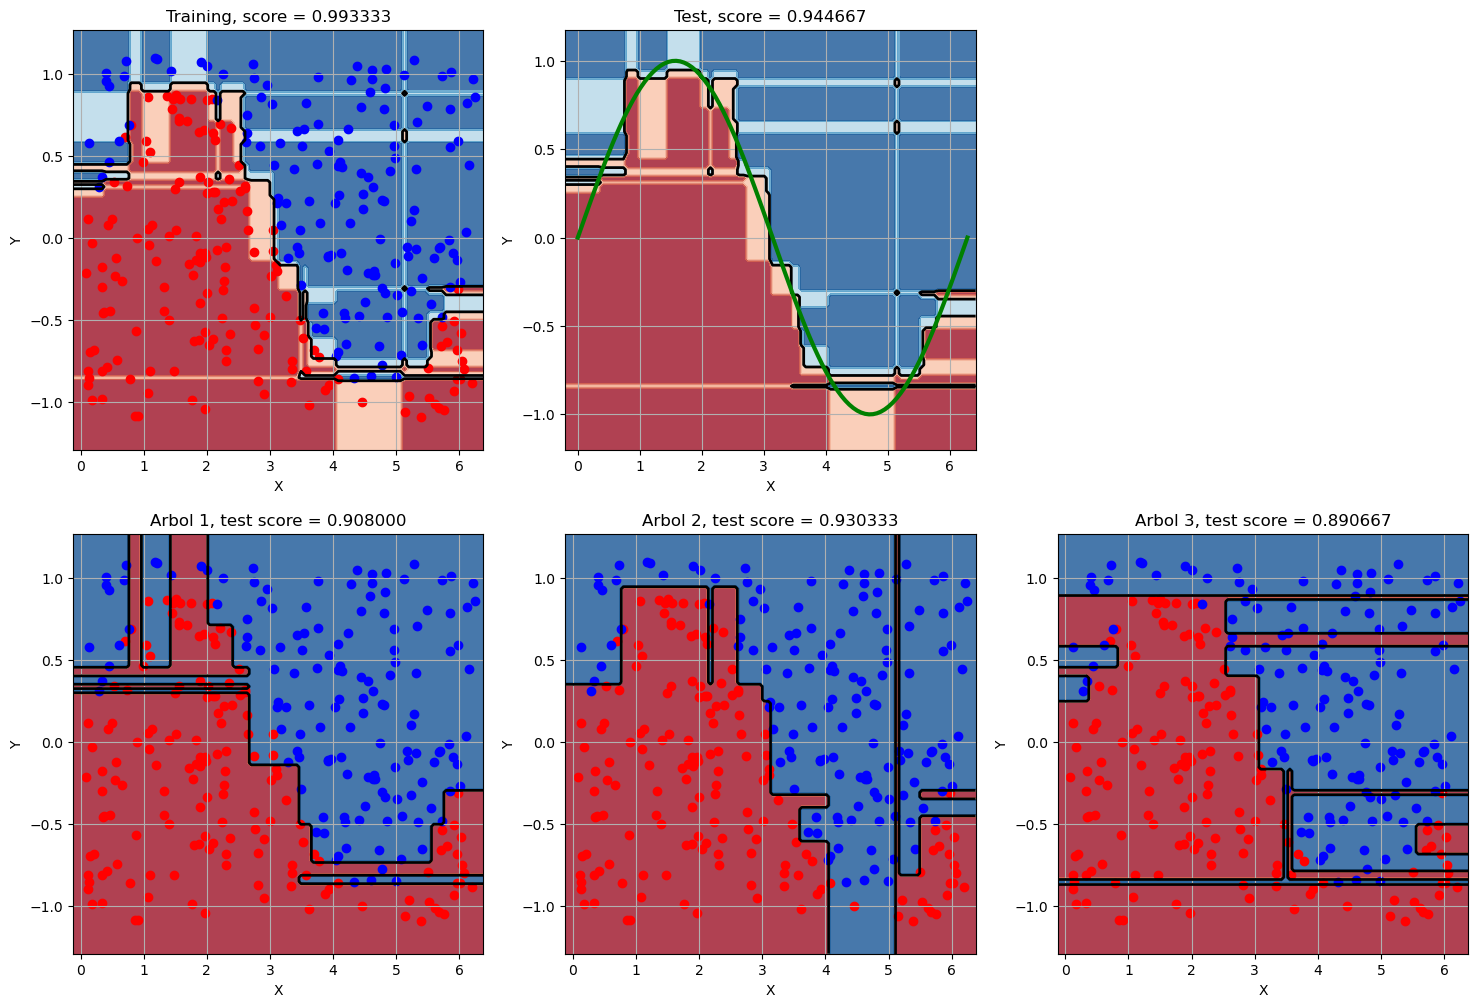

In [7]:
# Construcción del clasificador:
np.random.seed(11)
clf = RandomForestClassifier(n_estimators=3) # <= Modif este valor 3, 31 y 301(antes responde a las cuestiones de arriba)
clf.fit(np.concatenate((x, y), axis = 1), np.ravel(clase))  

# Calculo del acierto en los conjuntos de entrenamiento y test:
score_train = clf.score(np.concatenate((x, y), axis = 1), np.ravel(clase))
print("Score train = %f" % (score_train))
score_test = clf.score(np.concatenate((xtest, ytest), axis = 1), np.ravel(clasetest))
print("Score test = %f" % (score_test))

scores_single_trees_test = [dt.score(np.concatenate((xtest, ytest), axis = 1), np.ravel(clasetest))
                            for dt in clf.estimators_[0:3]]

print("Score test tres primeros árboles = %f,%f,%f" % tuple(scores_single_trees_test))


# Gráficas:
plt.figure(figsize=(18,12))
plt.subplot(231)
plotModel(x,y,clase,clf,"Training, score = %f" % (score_train))
plt.subplot(234)
plotModel(x,y,clase,clf.estimators_[0],"Arbol 1, test score = %f" % (scores_single_trees_test[0]))
plt.subplot(235)
plotModel(x,y,clase,clf.estimators_[1],"Arbol 2, test score = %f" % (scores_single_trees_test[1]))
plt.subplot(236)
plotModel(x,y,clase,clf.estimators_[2],"Arbol 3, test score = %f" % (scores_single_trees_test[2]))

plt.subplot(232)
plotModel(xbnd,ybnd,None,clf,"Test, score = %f" % (score_test))


Score train = 1.000000
Score test = 0.954333
Score test tres primeros árboles = 0.908000,0.930333,0.890667


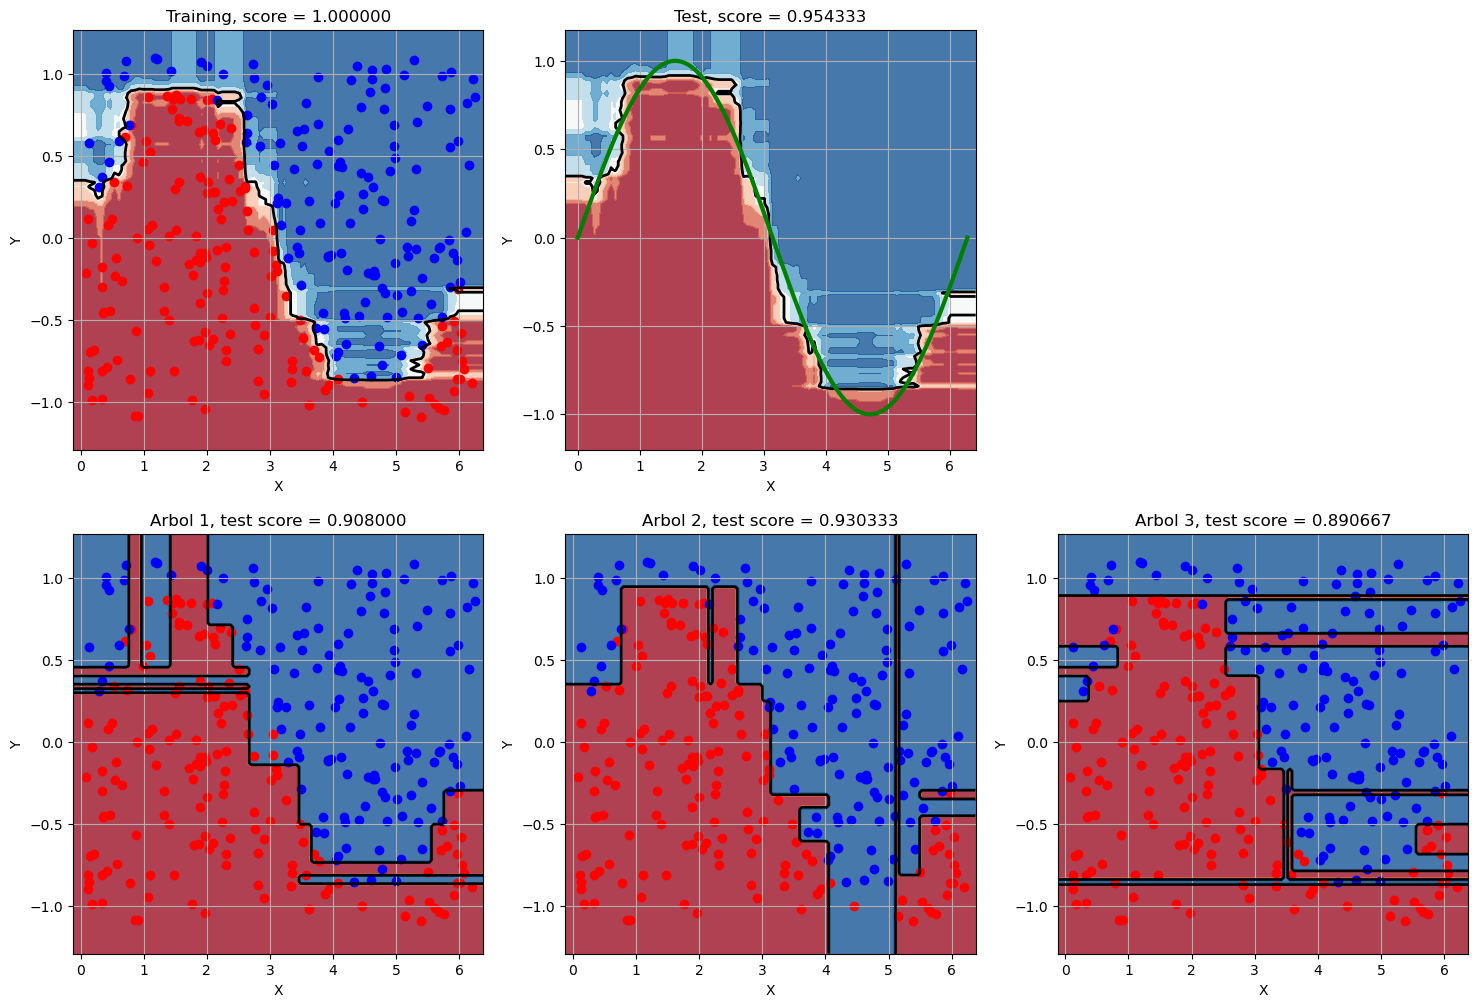

In [8]:
np.random.seed(11)
n = 300
model = 'sine'
ymargin = 0.
noise = 0.0                  # <========= Modifica este valor 0 ó 0.3, (antes responde a las cuestiones de arriba)
x, y, clase, xbnd, ybnd = createDataSet(n, model, ymargin, noise, True)
xtest, ytest, clasetest = createDataSet(n*10, model, ymargin, noise)


# Construcción del clasificador:
np.random.seed(11)
clf = RandomForestClassifier(n_estimators=31) # <= Modif este valor 3, 31 y 301(antes responde a las cuestiones de arriba)
clf.fit(np.concatenate((x, y), axis = 1), np.ravel(clase))  

# Calculo del acierto en los conjuntos de entrenamiento y test:
score_train = clf.score(np.concatenate((x, y), axis = 1), np.ravel(clase))
print("Score train = %f" % (score_train))
score_test = clf.score(np.concatenate((xtest, ytest), axis = 1), np.ravel(clasetest))
print("Score test = %f" % (score_test))

scores_single_trees_test = [dt.score(np.concatenate((xtest, ytest), axis = 1), np.ravel(clasetest))
                            for dt in clf.estimators_[0:3]]

print("Score test tres primeros árboles = %f,%f,%f" % tuple(scores_single_trees_test))


# Gráficas:
plt.figure(figsize=(18,12))
plt.subplot(231)
plotModel(x,y,clase,clf,"Training, score = %f" % (score_train))
plt.subplot(234)
plotModel(x,y,clase,clf.estimators_[0],"Arbol 1, test score = %f" % (scores_single_trees_test[0]))
plt.subplot(235)
plotModel(x,y,clase,clf.estimators_[1],"Arbol 2, test score = %f" % (scores_single_trees_test[1]))
plt.subplot(236)
plotModel(x,y,clase,clf.estimators_[2],"Arbol 3, test score = %f" % (scores_single_trees_test[2]))

plt.subplot(232)
plotModel(xbnd,ybnd,None,clf,"Test, score = %f" % (score_test))

Score train = 1.000000
Score test = 0.953000
Score test tres primeros árboles = 0.908000,0.930333,0.890667


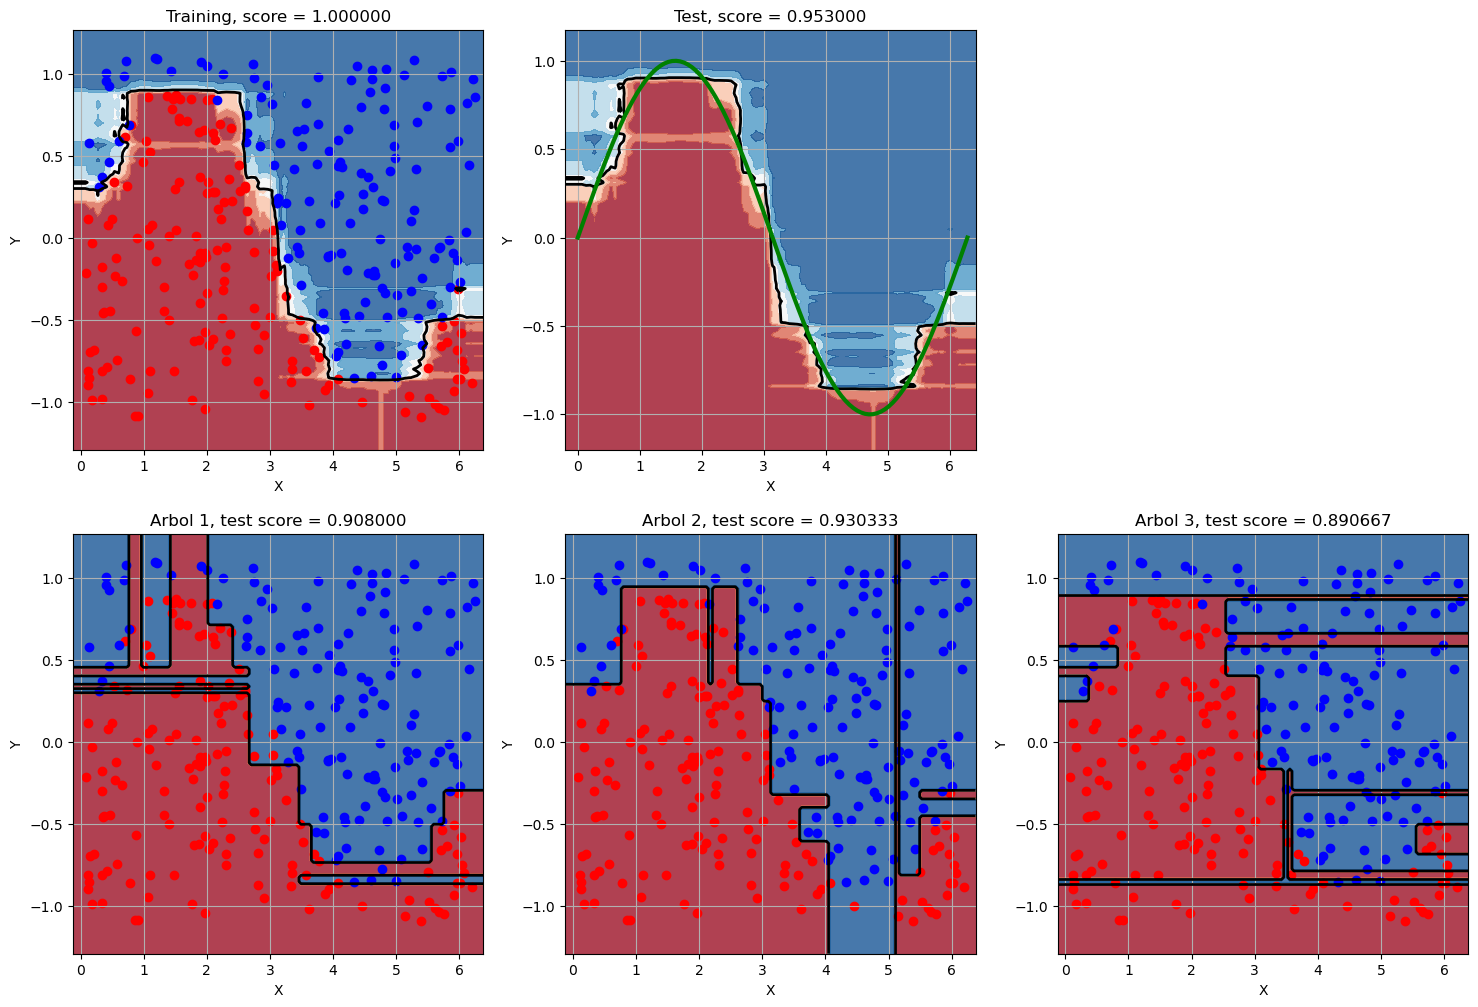

In [9]:
np.random.seed(11)
n = 300
model = 'sine'
ymargin = 0.
noise = 0.0                  # <========= Modifica este valor 0 ó 0.3, (antes responde a las cuestiones de arriba)
x, y, clase, xbnd, ybnd = createDataSet(n, model, ymargin, noise, True)
xtest, ytest, clasetest = createDataSet(n*10, model, ymargin, noise)


# Construcción del clasificador:
np.random.seed(11)
clf = RandomForestClassifier(n_estimators=301) # <= Modif este valor 3, 31 y 301(antes responde a las cuestiones de arriba)
clf.fit(np.concatenate((x, y), axis = 1), np.ravel(clase))  

# Calculo del acierto en los conjuntos de entrenamiento y test:
score_train = clf.score(np.concatenate((x, y), axis = 1), np.ravel(clase))
print("Score train = %f" % (score_train))
score_test = clf.score(np.concatenate((xtest, ytest), axis = 1), np.ravel(clasetest))
print("Score test = %f" % (score_test))

scores_single_trees_test = [dt.score(np.concatenate((xtest, ytest), axis = 1), np.ravel(clasetest))
                            for dt in clf.estimators_[0:3]]

print("Score test tres primeros árboles = %f,%f,%f" % tuple(scores_single_trees_test))


# Gráficas:
plt.figure(figsize=(18,12))
plt.subplot(231)
plotModel(x,y,clase,clf,"Training, score = %f" % (score_train))
plt.subplot(234)
plotModel(x,y,clase,clf.estimators_[0],"Arbol 1, test score = %f" % (scores_single_trees_test[0]))
plt.subplot(235)
plotModel(x,y,clase,clf.estimators_[1],"Arbol 2, test score = %f" % (scores_single_trees_test[1]))
plt.subplot(236)
plotModel(x,y,clase,clf.estimators_[2],"Arbol 3, test score = %f" % (scores_single_trees_test[2]))

plt.subplot(232)
plotModel(xbnd,ybnd,None,clf,"Test, score = %f" % (score_test))

Score train = 0.966667
Score test = 0.827667
Score test tres primeros árboles = 0.821000,0.767000,0.795667


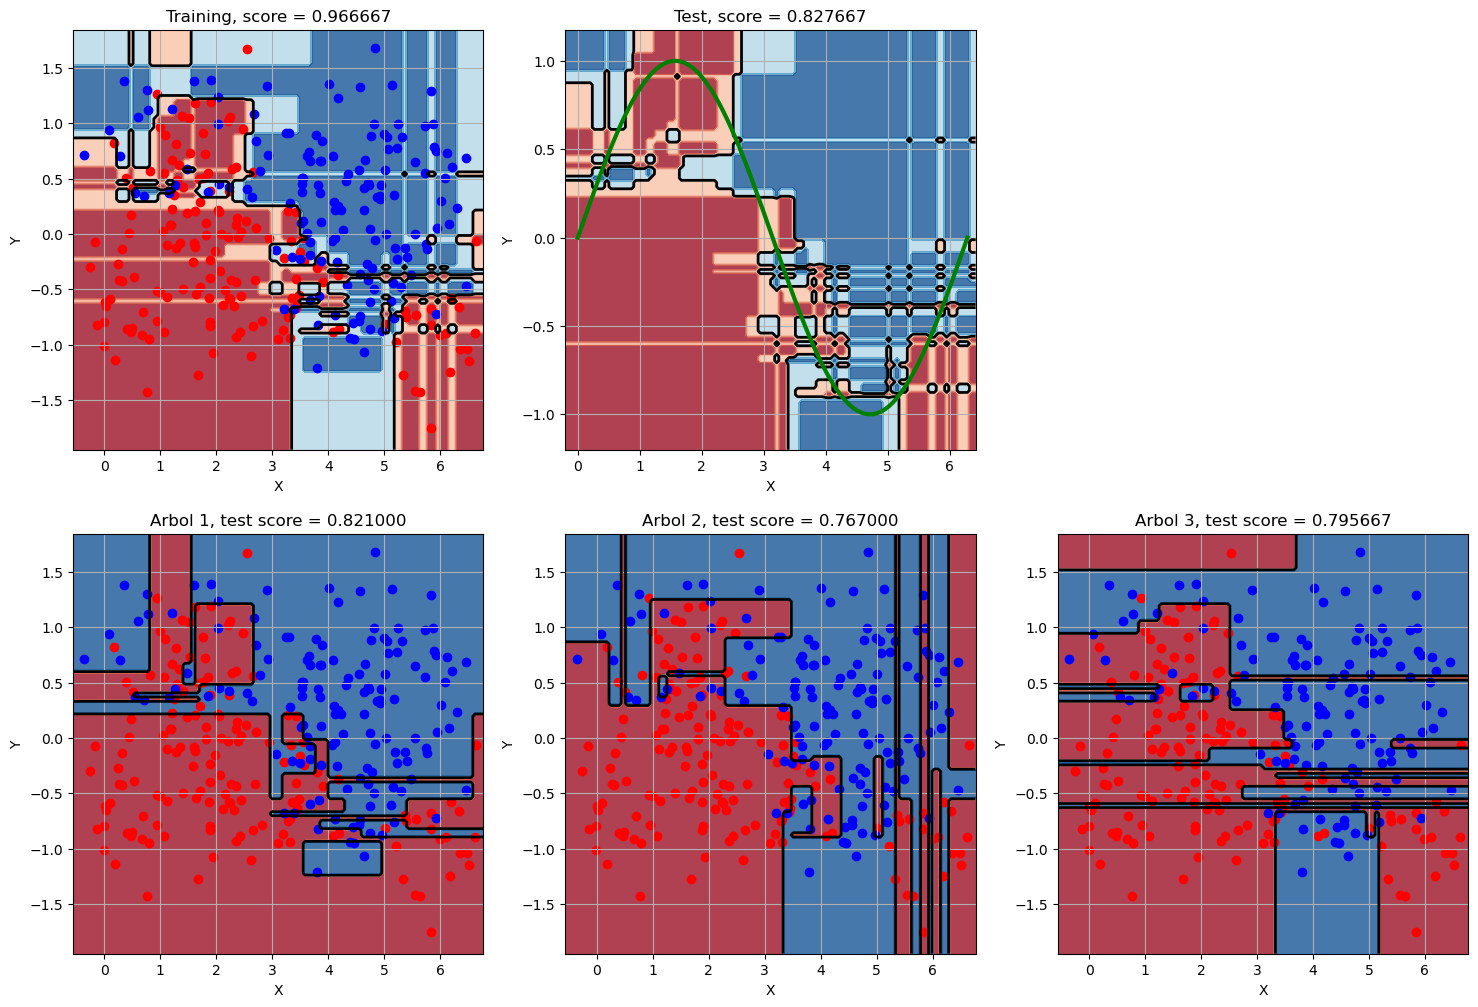

In [10]:
np.random.seed(11)
n = 300
model = 'sine'
ymargin = 0.
noise = 0.3                  # <========= Modifica este valor 0 ó 0.3, (antes responde a las cuestiones de arriba)
x, y, clase, xbnd, ybnd = createDataSet(n, model, ymargin, noise, True)
xtest, ytest, clasetest = createDataSet(n*10, model, ymargin, noise)


# Construcción del clasificador:
np.random.seed(11)
clf = RandomForestClassifier(n_estimators=3) # <= Modif este valor 3, 31 y 301(antes responde a las cuestiones de arriba)
clf.fit(np.concatenate((x, y), axis = 1), np.ravel(clase))  

# Calculo del acierto en los conjuntos de entrenamiento y test:
score_train = clf.score(np.concatenate((x, y), axis = 1), np.ravel(clase))
print("Score train = %f" % (score_train))
score_test = clf.score(np.concatenate((xtest, ytest), axis = 1), np.ravel(clasetest))
print("Score test = %f" % (score_test))

scores_single_trees_test = [dt.score(np.concatenate((xtest, ytest), axis = 1), np.ravel(clasetest))
                            for dt in clf.estimators_[0:3]]

print("Score test tres primeros árboles = %f,%f,%f" % tuple(scores_single_trees_test))


# Gráficas:
plt.figure(figsize=(18,12))
plt.subplot(231)
plotModel(x,y,clase,clf,"Training, score = %f" % (score_train))
plt.subplot(234)
plotModel(x,y,clase,clf.estimators_[0],"Arbol 1, test score = %f" % (scores_single_trees_test[0]))
plt.subplot(235)
plotModel(x,y,clase,clf.estimators_[1],"Arbol 2, test score = %f" % (scores_single_trees_test[1]))
plt.subplot(236)
plotModel(x,y,clase,clf.estimators_[2],"Arbol 3, test score = %f" % (scores_single_trees_test[2]))

plt.subplot(232)
plotModel(xbnd,ybnd,None,clf,"Test, score = %f" % (score_test))

Score train = 1.000000
Score test = 0.847333
Score test tres primeros árboles = 0.821000,0.767000,0.795667


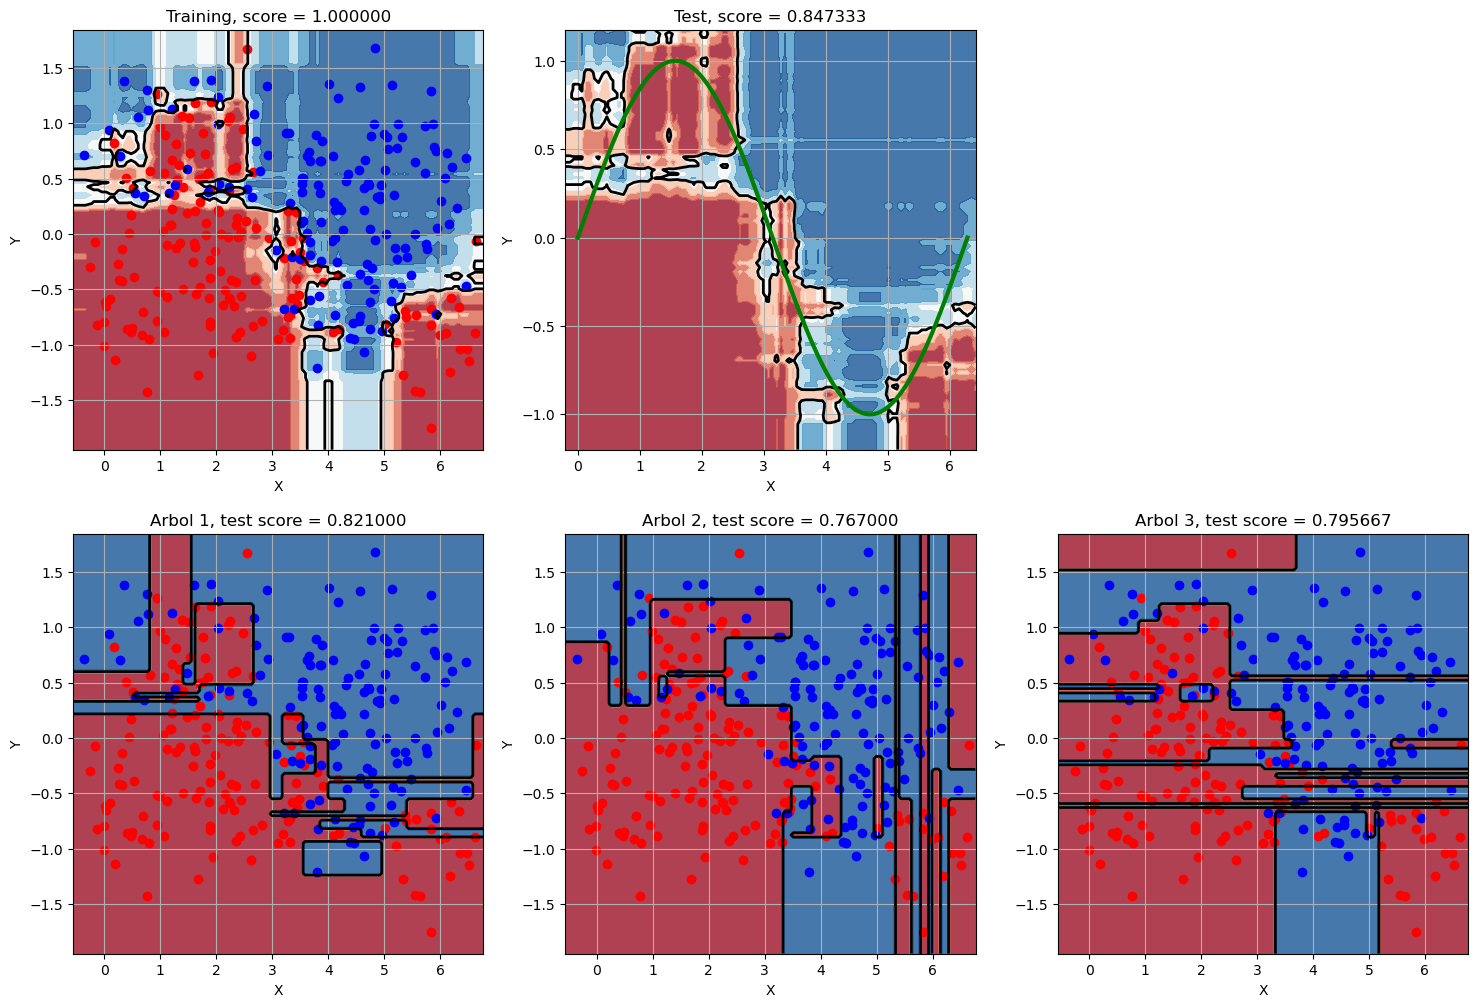

In [11]:
np.random.seed(11)
n = 300
model = 'sine'
ymargin = 0.
noise = 0.3                  # <========= Modifica este valor 0 ó 0.3, (antes responde a las cuestiones de arriba)
x, y, clase, xbnd, ybnd = createDataSet(n, model, ymargin, noise, True)
xtest, ytest, clasetest = createDataSet(n*10, model, ymargin, noise)


# Construcción del clasificador:
np.random.seed(11)
clf = RandomForestClassifier(n_estimators=31) # <= Modif este valor 3, 31 y 301(antes responde a las cuestiones de arriba)
clf.fit(np.concatenate((x, y), axis = 1), np.ravel(clase))  

# Calculo del acierto en los conjuntos de entrenamiento y test:
score_train = clf.score(np.concatenate((x, y), axis = 1), np.ravel(clase))
print("Score train = %f" % (score_train))
score_test = clf.score(np.concatenate((xtest, ytest), axis = 1), np.ravel(clasetest))
print("Score test = %f" % (score_test))

scores_single_trees_test = [dt.score(np.concatenate((xtest, ytest), axis = 1), np.ravel(clasetest))
                            for dt in clf.estimators_[0:3]]

print("Score test tres primeros árboles = %f,%f,%f" % tuple(scores_single_trees_test))


# Gráficas:
plt.figure(figsize=(18,12))
plt.subplot(231)
plotModel(x,y,clase,clf,"Training, score = %f" % (score_train))
plt.subplot(234)
plotModel(x,y,clase,clf.estimators_[0],"Arbol 1, test score = %f" % (scores_single_trees_test[0]))
plt.subplot(235)
plotModel(x,y,clase,clf.estimators_[1],"Arbol 2, test score = %f" % (scores_single_trees_test[1]))
plt.subplot(236)
plotModel(x,y,clase,clf.estimators_[2],"Arbol 3, test score = %f" % (scores_single_trees_test[2]))

plt.subplot(232)
plotModel(xbnd,ybnd,None,clf,"Test, score = %f" % (score_test))

Score train = 1.000000
Score test = 0.851000
Score test tres primeros árboles = 0.821000,0.767000,0.795667


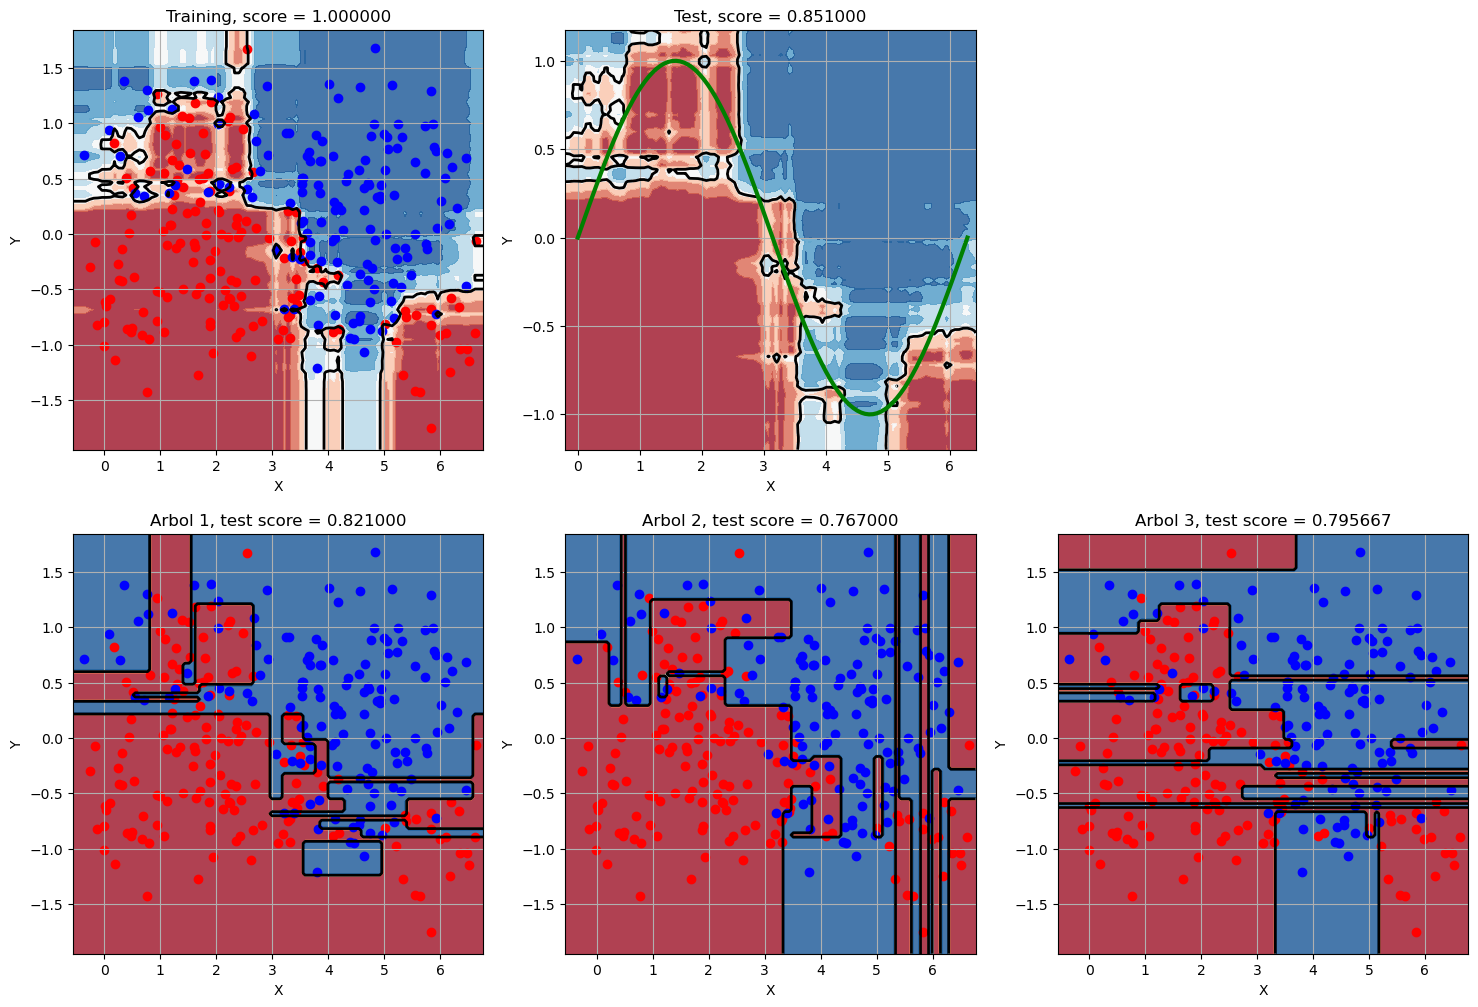

In [12]:
np.random.seed(11)
n = 300
model = 'sine'
ymargin = 0.
noise = 0.3                  # <========= Modifica este valor 0 ó 0.3, (antes responde a las cuestiones de arriba)
x, y, clase, xbnd, ybnd = createDataSet(n, model, ymargin, noise, True)
xtest, ytest, clasetest = createDataSet(n*10, model, ymargin, noise)


# Construcción del clasificador:
np.random.seed(11)
clf = RandomForestClassifier(n_estimators=301) # <= Modif este valor 3, 31 y 301(antes responde a las cuestiones de arriba)
clf.fit(np.concatenate((x, y), axis = 1), np.ravel(clase))  

# Calculo del acierto en los conjuntos de entrenamiento y test:
score_train = clf.score(np.concatenate((x, y), axis = 1), np.ravel(clase))
print("Score train = %f" % (score_train))
score_test = clf.score(np.concatenate((xtest, ytest), axis = 1), np.ravel(clasetest))
print("Score test = %f" % (score_test))

scores_single_trees_test = [dt.score(np.concatenate((xtest, ytest), axis = 1), np.ravel(clasetest))
                            for dt in clf.estimators_[0:3]]

print("Score test tres primeros árboles = %f,%f,%f" % tuple(scores_single_trees_test))


# Gráficas:
plt.figure(figsize=(18,12))
plt.subplot(231)
plotModel(x,y,clase,clf,"Training, score = %f" % (score_train))
plt.subplot(234)
plotModel(x,y,clase,clf.estimators_[0],"Arbol 1, test score = %f" % (scores_single_trees_test[0]))
plt.subplot(235)
plotModel(x,y,clase,clf.estimators_[1],"Arbol 2, test score = %f" % (scores_single_trees_test[1]))
plt.subplot(236)
plotModel(x,y,clase,clf.estimators_[2],"Arbol 3, test score = %f" % (scores_single_trees_test[2]))

plt.subplot(232)
plotModel(xbnd,ybnd,None,clf,"Test, score = %f" % (score_test))

<div style="background-color:#AAEEAA;padding:20px;border:solid;">A continuación se realiza el cálculo el acierto del conjunto con en train y en test con respecto al número de clasificadores combinados. Puedes utilizar la función suministrada individualPredictions, que dado un conjunto de datos y otro de clasificadores devuelve las clasificaciones de cada clasificador base para cada ejemplo
</div>

In [13]:
# individualPredictions: Devuelve la predicción para cada dato por parte de cada clasificador 
#                        de un conjunto de clasificadores
#     Entrada:
#         - ens: lista con un conjunto de clasificadores
#         - X  : ejemplos a clasificar
#     Salida:
#         - Matriz de predicciones de número de ejemplo filas y no. clasificadores columnas
def individualPredictions(ens, X):
    P = np.ones((X.shape[0],len(ens)))
    it = 0
    for dt in ens:
        P[:,it] = dt.predict(X)
        it += 1

    return P



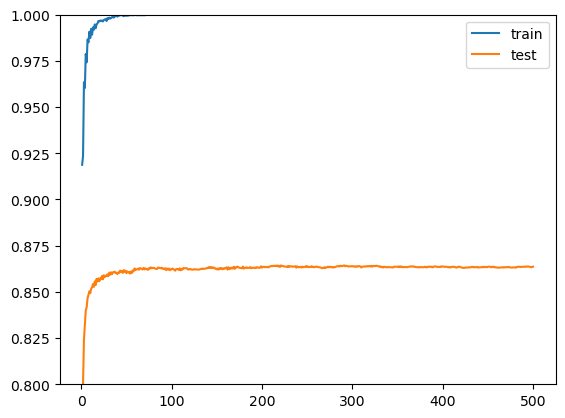

In [14]:
from sklearn.model_selection import train_test_split
import pandas as pd

def accuracy(ens, pr, y):
    pr = np.cumsum(pr,axis=1)/np.arange(1.,pr.shape[1]+1,1.)
    pr[pr>0.5] = 1
    pr[pr<=0.5] = 0

    iclases_test = np.zeros(np.array([y]).T.shape)
    iclases_test[y==ens.classes_[0]] = 0
    iclases_test[y==ens.classes_[1]] = 1

    Pok = pr==iclases_test
    return np.array(Pok.sum(axis=0),dtype=float)/len(y)

    
# Cargamos datos
fP = 'magic04.csv'
dfP = pd.read_csv(fP, sep=',')
lVarsTarg = dfP.columns

#separación training-test
X_train, X_test, clases_train, clases_test = train_test_split(dfP.values[:,:-1], dfP.values[:,-1], test_size=0.8, random_state=1)

n_trees = 500
clf = RandomForestClassifier(n_estimators=n_trees)
clf.fit(X_train, clases_train)

P = individualPredictions(clf.estimators_, X_train)
accu_tr = accuracy(clf,P,clases_train)

P = individualPredictions(clf.estimators_, X_test)
accu_ts = accuracy(clf,P,clases_test)

plt.plot(range(1,n_trees+1),accu_tr,label="train")
plt.plot(range(1,n_trees+1),accu_ts,label="test")
plt.ylim([0.8,1])
_ = plt.legend()


<div style="background-color:#AAEEAA;padding:20px;border:solid;">Usando la tabla y la gráfica describe cómo evoluciona el error en en entrenemiento y test con respecto al número de árboles que se combinan en el conjunto ¿Se observa sobre ajuste al aumentar el número de clasificadores? Es decir, ¿sube el error en test a partir de algún umbral del número de clasificadores?<br/></div>
<br/>
<div style="background-color:#EEEEAA;padding:20px;border:solid;">(5) Respuesta: 

- En general, **la precisión de entrenamiento** aumenta a medida que aumenta el número de árboles (n_estimators) para ambos **niveles de ruido (0 y 0.3)**. En el gráfico, la línea azul (train) lo refleja al subir hacia 1.0 (100% de precisión) con más árboles (eje x). Este aumento de la precisión de entrenamiento probablemente se deba al sobreajuste.

- **Sin ruido (noise=0), la precisión de prueba** aumenta ligeramente de 3 a 31 árboles (de 0.944667 a 0.954333), según la tabla. Hay una pequeña disminución de 31 a 301 árboles (0.953000). La línea naranja (test) en el gráfico refleja esto, subiendo ligeramente hasta 31 árboles y luego estabilizándose.

- **Con ruido (noise=0.3), la precisión de prueba** sigue una tendencia similar (según la tabla). Aumenta ligeramente de 3 a 31 árboles (de 0.827667 a 0.847333) y luego muestra un pequeño aumento nuevamente con 301 árboles (0.851000). La línea naranja (test) en el gráfico con ruido=0.3 lo refleja, aumentando ligeramente hasta 31 árboles y luego estabilizándose.

Aumentar el número de árboles puede conducir a sobreajuste en el entrenamiento. Sin embargo, la aleatoriedad durante el entrenamiento (subconjuntos de características y criterios de división) ayuda a evitar que esto afecte significativamente el rendimiento de la prueba.

La tabla muestra que aumentar el número de árboles en el conjunto puede ayudar a reducir la varianza en el modelo, pero también puede conducir a sobreajuste. En este caso, **usar más de 31 árboles no mejora** significativamente el precisión de prueba e incluso podría conducir a sobreajuste, especialmente para datos sin ruido.


</div>

### Gradient Boosting para regresión



In [15]:
from sklearn.tree import DecisionTreeRegressor

def plot_par(t,x,y,res,pred,F):
    m = np.floor(np.min(y)-1)
    M = np.ceil(np.max(y)+1)
    plt.subplot(T,2,t*2+1)
    plt.stem(x,res,label='residuos')
    plt.plot(x,pred,label='h'+str(t),c='y')
    plt.ylim((m,M))
    plt.legend()
    plt.subplot(T,2,t*2+2)
    plt.plot(x,y,label='objetivo')
    plt.plot(x,F,label='F'+str(t),c='y')
    plt.ylim((m,M))
    plt.legend()

class SquaredErrorLoss:
    def F0(_, X, y):
        return np.ones(len(X))*np.mean(y)

    def residuos(_, y,F):
        return y - F

    def paso_newton(_, y, res, pred):
        return 1
    
class LogLoss:
    def F0(_, X, y):
        ymed = np.mean(y)
        return np.ones(len(X)) * 0.5 * np.log((1+ymed)/(1-ymed))

    def residuos(_, y,F):
        return 2.0*y/(1+np.exp(2.0*y*F))

    def paso_newton(_, y, res, pred):
        return np.sum(res*pred)/np.sum(res*pred*pred*(2.0*y-res))    
     
def GB(x,y,loss,T):
    F = loss.F0(x, y)

    #plotting
    plt.figure(figsize=(12, T*4))
    plot_par(0,x,y,y,F,F)

    for t in range(1,T):
        res = loss.residuos(y,F)
        # Modelo ajustado a residuos
        lr = DecisionTreeRegressor(max_depth=1)
        lr.fit(x.reshape(-1,1),res)
        # Update
        pred = lr.predict(x.reshape(-1,1))
        paso = loss.paso_newton(y, res, pred)
        
        F = F + paso*pred
        #plotting
        plot_par(t,x,y,res,pred,F)


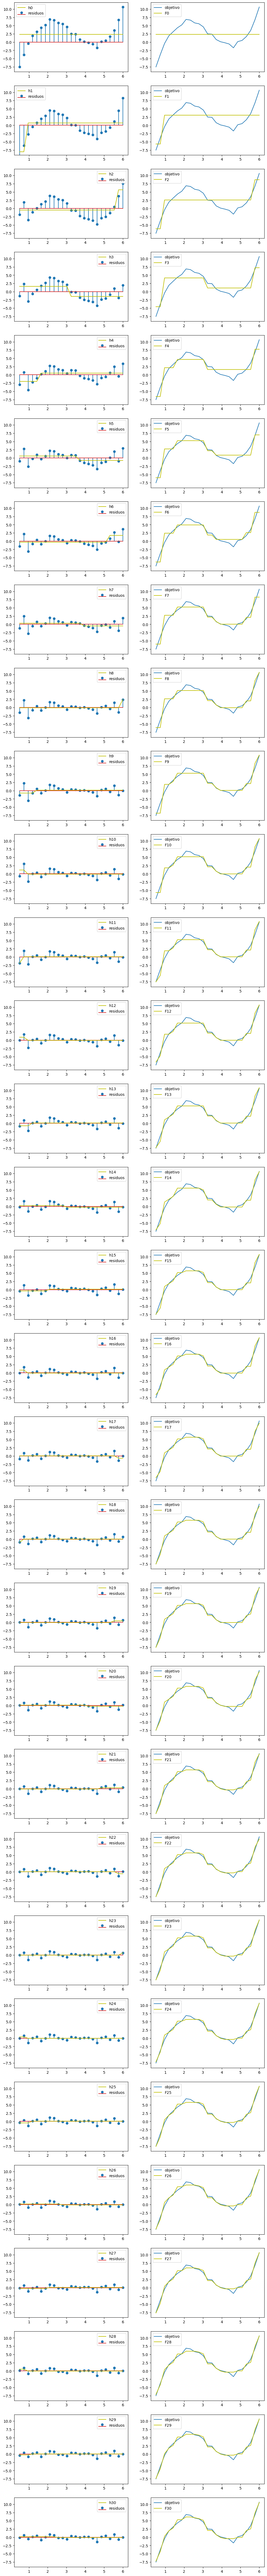

In [16]:
T = 31

# Gradient boosting ejemplo
def polinomio(x):
    return (x-1)*(x-4)*(x-5) + np.random.randn(len(x))*0.5

x = np.linspace(0.5,6,25)
y = polinomio(x)

loss = SquaredErrorLoss()

GB(x,y,loss,T)

### Gradient Boosting para clasificación

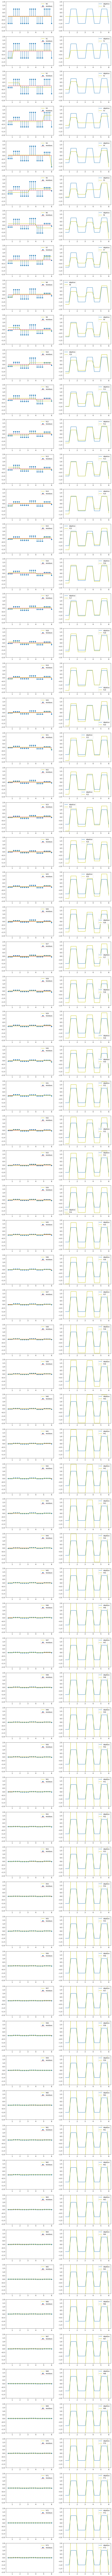

In [17]:
T = 74

# Gradient boosting ejemplo
def polinomio(x):
    return ((x + np.random.randn(len(x))*0.15).astype(int) % 2 ) * 2 - 1

x = np.linspace(0.5,6,25)
y = polinomio(x)

loss = LogLoss()

GB(x,y,loss,T)

#plt.savefig("clasf_gb.svg")

### 2.- Tiempos de entrenamiento y test de los árboles de decisión
Vamos a medir tiempos de entrenamiento y clasificación de árboles de decisión y a compararlos con los tiempos de las SVMs. Probaremos a entrenar los modelos con 300 datos y con 600


In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split
import sklearn.preprocessing as skpp
import timeit
from sklearn.svm import SVC

n_executions = 1

# Cargamos datos
fP = 'pimaND.csv'
dfP = pd.read_csv(fP, sep=',')
lVarsTarg = dfP.columns

# Dividimos train/test
n_train = 300                                      # <================== Modificar 300 o 600
perm = np.random.permutation(dfP.shape[0])
indices_train = perm[0:n_train]
indices_test  = perm[n_train:]

    
#clf = SVC(C=10.0, kernel='linear', degree=1.0, coef0=1.0, gamma=0.1) # <================== Modificar DT o SVM
#clf = tree.DecisionTreeClassifier()
clf = RandomForestClassifier(n_estimators=100)  # <================== Modificar 100 o 1000

# Tiempo de entrenamiento
tic = timeit.default_timer()
for ie in range(n_executions):    # Puede ser necesario ejecutarlo varias veces para obtener tiempos más estables
    clf.fit(dfP.values[indices_train,:-1],dfP.values[indices_train,-1])
toc = timeit.default_timer()

print("Tiempo de entrenamiento con {} ejemplos: {:.4g} s.".format(len(indices_train),(toc - tic)/n_executions))

n_executions = 10

# Tiempo de clasificacion
tic = timeit.default_timer()
for ie in range(n_executions):   # Puede ser necesario ejecutarlo varias veces para obtener tiempos más estables
    _ = clf.predict(dfP.values[indices_test,:-1])
toc = timeit.default_timer()

factor = 100.
print("Tiempo de clasificar {:g} ejemplos: {:.4g} s.".format(factor, factor*(toc - tic)/n_executions/len(indices_test)))

Tiempo de entrenamiento con 300 ejemplos: 0.07064 s.
Tiempo de clasificar 100 ejemplos: 0.001414 s.


In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
import sklearn.preprocessing as skpp
import timeit
from sklearn.svm import SVC

n_executions = 1

# Cargamos datos
fP = 'pimaND.csv'
dfP = pd.read_csv(fP, sep=',')
lVarsTarg = dfP.columns

# Dividimos train/test
n_train = 300                                      # <================== Modificar 300 o 600
perm = np.random.permutation(dfP.shape[0])
indices_train = perm[0:n_train]
indices_test  = perm[n_train:]

    
#clf = SVC(C=10.0, kernel='linear', degree=1.0, coef0=1.0, gamma=0.1) # <================== Modificar DT o SVM
#clf = tree.DecisionTreeClassifier()
clf = RandomForestClassifier(n_estimators=1000)  # <================== Modificar 100 o 1000

# Tiempo de entrenamiento
tic = timeit.default_timer()
for ie in range(n_executions):    # Puede ser necesario ejecutarlo varias veces para obtener tiempos más estables
    clf.fit(dfP.values[indices_train,:-1],dfP.values[indices_train,-1])
toc = timeit.default_timer()

print("Tiempo de entrenamiento con {} ejemplos: {:.4g} s.".format(len(indices_train),(toc - tic)/n_executions))

n_executions = 10

# Tiempo de clasificacion
tic = timeit.default_timer()
for ie in range(n_executions):   # Puede ser necesario ejecutarlo varias veces para obtener tiempos más estables
    _ = clf.predict(dfP.values[indices_test,:-1])
toc = timeit.default_timer()

factor = 100.
print("Tiempo de clasificar {:g} ejemplos: {:.4g} s.".format(factor, factor*(toc - tic)/n_executions/len(indices_test)))

Tiempo de entrenamiento con 300 ejemplos: 0.6884 s.
Tiempo de clasificar 100 ejemplos: 0.01383 s.


In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split
import sklearn.preprocessing as skpp
import timeit
from sklearn.svm import SVC

n_executions = 1

# Cargamos datos
fP = 'pimaND.csv'
dfP = pd.read_csv(fP, sep=',')
lVarsTarg = dfP.columns

# Dividimos train/test
n_train = 600                                      # <================== Modificar 300 o 600
perm = np.random.permutation(dfP.shape[0])
indices_train = perm[0:n_train]
indices_test  = perm[n_train:]

    
#clf = SVC(C=10.0, kernel='linear', degree=1.0, coef0=1.0, gamma=0.1) # <================== Modificar DT o SVM
#clf = tree.DecisionTreeClassifier()
clf = RandomForestClassifier(n_estimators=100)  # <================== Modificar 100 o 1000

# Tiempo de entrenamiento
tic = timeit.default_timer()
for ie in range(n_executions):    # Puede ser necesario ejecutarlo varias veces para obtener tiempos más estables
    clf.fit(dfP.values[indices_train,:-1],dfP.values[indices_train,-1])
toc = timeit.default_timer()

print("Tiempo de entrenamiento con {} ejemplos: {:.4g} s.".format(len(indices_train),(toc - tic)/n_executions))

n_executions = 10

# Tiempo de clasificacion
tic = timeit.default_timer()
for ie in range(n_executions):   # Puede ser necesario ejecutarlo varias veces para obtener tiempos más estables
    _ = clf.predict(dfP.values[indices_test,:-1])
toc = timeit.default_timer()

factor = 100.
print("Tiempo de clasificar {:g} ejemplos: {:.4g} s.".format(factor, factor*(toc - tic)/n_executions/len(indices_test)))

Tiempo de entrenamiento con 600 ejemplos: 0.08806 s.
Tiempo de clasificar 100 ejemplos: 0.00316 s.


In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split
import sklearn.preprocessing as skpp
import timeit
from sklearn.svm import SVC

n_executions = 1

# Cargamos datos
fP = 'pimaND.csv'
dfP = pd.read_csv(fP, sep=',')
lVarsTarg = dfP.columns

# Dividimos train/test
n_train = 600                                      # <================== Modificar 300 o 600
perm = np.random.permutation(dfP.shape[0])
indices_train = perm[0:n_train]
indices_test  = perm[n_train:]

    
#clf = SVC(C=10.0, kernel='linear', degree=1.0, coef0=1.0, gamma=0.1) # <================== Modificar DT o SVM
#clf = tree.DecisionTreeClassifier()
clf = RandomForestClassifier(n_estimators=1000)  # <================== Modificar 100 o 1000

# Tiempo de entrenamiento
tic = timeit.default_timer()
for ie in range(n_executions):    # Puede ser necesario ejecutarlo varias veces para obtener tiempos más estables
    clf.fit(dfP.values[indices_train,:-1],dfP.values[indices_train,-1])
toc = timeit.default_timer()

print("Tiempo de entrenamiento con {} ejemplos: {:.4g} s.".format(len(indices_train),(toc - tic)/n_executions))

n_executions = 10

# Tiempo de clasificacion
tic = timeit.default_timer()
for ie in range(n_executions):   # Puede ser necesario ejecutarlo varias veces para obtener tiempos más estables
    _ = clf.predict(dfP.values[indices_test,:-1])
toc = timeit.default_timer()

factor = 100.
print("Tiempo de clasificar {:g} ejemplos: {:.4g} s.".format(factor, factor*(toc - tic)/n_executions/len(indices_test)))

Tiempo de entrenamiento con 600 ejemplos: 0.8749 s.
Tiempo de clasificar 100 ejemplos: 0.03102 s.


<div style="background-color:#AAEEAA;padding:20px;border:solid;">Se debe ejecutar la celda de arriba utilizando conjuntos de clasificadores con 100 y 1000 árboles. Hazlo usando 300 datos de entrenamiento y 600. A continuación se debe rellenar los tiempos en la siguiente tabla comparando con lo obtenido en con árboles y SVM:<br/></div>
<br/>
<div style="background-color:#EEEEAA;padding:20px;border:solid;">(6) Respuestas:

|  Tiempos (s)          | Árbol    | SVM       | RF100   | RF 1000 |
|-----------------------|----------|-----------|---------|---------|
| Entrenamiento con 300 | 0.001284 | 6.909231  | 0.07064 | 0.6884  |
| Entrenamiento con 600 | 0.001979 | 19.240841 | 0.08806 | 0.8749  |
| Clasificación con modelo entr. con 300 (10^6 ejemplos) | 0.178299 | 2.578594 | 0.001414 | 0.01383 |
| Clasificación con modelo entr. con 600 (10^6 ejemplos) | 0.436929 | 5.018220 | 0.00316  | 0.03102 |

(+) Recuperar datos de la práctica anterior

(++) Rellenar estos datos ejecutando el código de arriba
</div>
<br/>

<div style="background-color:#AAEEAA;padding:20px;border:solid;">Usando la tabla comenta los resultados.<br/>

<ul>
<li>(7) ¿Cómo varían los tiempos de entrenamiento al doblar el número de datos de entrenamiento? ¿Y los tiempos de clasificación?</li>
<li>(8): Explica los resultados y comparalos con los de un solo árbol</li>
</ul>
</div>
<br/>
<div style="background-color:#EEEEAA;padding:20px;border:solid;">Respuesta:

<ul>
<li>(7): 

**Tiempo de Entrenamiento:**

Recordando lo anterior:

**SVC:** El tiempo de entrenamiento aumenta linealmente con el número de ejemplos de entrenamiento. Para 300 ejemplos, tarda 6.91 segundos, y para 600 ejemplos, 19.24 segundos.

**DT:** El tiempo de entrenamiento para DT es significativamente más rápido que para SVC. Para 300 ejemplos, tarda 0.0012 segundos, y para 600 ejemplos, 0.0019 segundos.

Observando RandomForestClassifier con n_estimators (número de árboles) = 100 y 1000:

**RF100:** Con n_estimators = 100, el tiempo de entrenamiento aumenta ligeramente a medida que aumenta el número de ejemplos de entrenamiento. Para 300 ejemplos de entrenamiento, es de 0.071 segundos, y para 600 ejemplos, de 0.09 segundos.

**RF1000:** Si configuramos n_estimators = 1000, el tiempo de entrenamiento aumenta a medida que aumenta el número de ejemplos de entrenamiento. Para 300 ejemplos de entrenamiento, es de 0.69 segundos, y para 600 ejemplos, de 0.87 segundos. Como era de esperar, es más lento que el parámetro n_estimators = 100 debido al aumento del número de árboles.

**Tiempo de Clasificación:**

**SVC:** Para SVC, el tiempo de clasificación aumenta linealmente con el número de ejemplos. Para 1 millón de ejemplos, tarda aproximadamente 2.57 segundos para 300 ejemplos de entrenamiento y 5.018 segundos para 600 ejemplos de entrenamiento.

**DT:** El tiempo de clasificación para DT también es más rápido que para SVC, pero la diferencia es menos significativa. Para 1 millón de ejemplos, tarda aproximadamente 0.17 segundos para 300 ejemplos de entrenamiento y 0.43 segundos para 600 ejemplos de entrenamiento.
    
Observando RandomForestClassifier con n_estimators (número de árboles) = 100 y 1000:

**RF100:** Con n_estimators = 100, el tiempo de clasificación aumenta ligeramente a medida que aumenta el número de ejemplos de entrenamiento. Para 1 millón de ejemplos, es de 0.0014 segundos para 300 ejemplos de entrenamiento y de 0.00316 segundos para 600 ejemplos de entrenamiento.

**RF1000:** Si configuramos n_estimators = 1000, el tiempo de clasificación aumenta a medida que aumenta el número de ejemplos de entrenamiento. Para 1 millón de ejemplos, es de 0.014 segundos para 300 ejemplos de entrenamiento y de 0.031 segundos para 600 ejemplos de entrenamiento. Como era de esperar, es 10 veces más lento que el parámetro n_estimators = 100 debido al aumento de 10 veces en el número de árboles. Porque más árboles significa más cálculos para cada división y suma.



</li>

<li>(8): 

**La diferencia de velocidad:**

Los árboles de decisión son más rápidos de entrenar y clasificar que SVC porque su creación es más simple y se pueden paralelizar más fácilmente (la división de cada nodo es independiente de los demás).

Random Forest está compuesto por varios árboles de decisión, cada uno entrenado de forma independiente, lo que también permite la paralelización. Por lo tanto, es más rápido que SVC. Sin embargo, el aumento del número de árboles ("n_estimators") implica más cálculos, lo que ralentiza el entrenamiento y la clasificación.

SVC implica la resolución de un problema de optimización de segundo grado, lo que es computacionalmente intensivo. La paralelización también es limitada en este caso.Es el método más lento debido a la complejidad de la optimización del hiperplano.


**El tiempo de entrenamiento** de Decision Tree es más rápido que el tiempo de Random Forest porque los árboles de decisión son más sencillos de construir y más fáciles de paralelizar. Random Forest puede ser ligeramente más lento porque consta de más de un árbol de decisión. 

Random Forest combina las predicciones de varios árboles y, para cada muestra, las predicciones se agregan en todos los árboles. Así, se realizan múltiples predicciones. Decision Tree toma decisiones locales en cada nodo durante la clasificación y sólo se realiza una predicción por muestra. Por lo tanto, Random Forest es más rápido en **el tiempo de clasificación**.


</li>
</ul></div>

### 3.- Comparativa
Vamos a comparar los resultados de clasificación de algunos conjuntos de clasificadores y árboles de decisión.

<div style="background-color:#AAEEAA;padding:20px;border:solid;">Completa el código de abajo para comparar un árbol de decisión y los conjuntos bagging, adaboost y random forest. Se debe obtener el acierto para los conjuntos de datos: pimaND, spamND, magic04 y sonar. Esto se hará usando validación cruzada de 10 hojas.<br/>
</div>

In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn import tree

# Lista con los ficheros de datos
dataset_names = ['sensors.csv', 'pimaND.csv', 'spamND.csv', 'sonar.csv', 'magic04.csv']
# Cargo un conjunto de datos
idata=1
d = pd.read_csv(dataset_names[idata], sep=',')
print(dataset_names[idata])

# Creamos las particiones en entrenamiento y test para probar los distintos modelos
# Es importente que la partición sea igual para todos los modelos de forma que los 
# errores sean comparables. Eso se puede lograr fijando el random_state
indexFolds = KFold(n_splits=10, shuffle=True, random_state=11)

# Para conjuntos grades (pe. magic) puede que hacer entrenamiento con el 90% de los datos (como
#   sucede con KFold usando n_folds=10) sea inviable. Si tarde damasiado puedes usar la siguiente línea
#   para magic y tal vez para spamND
#indexFolds = cross_validation.ShuffleSplit(*** RELLENAR AQUI EL TAMAÑO DEL CONJUNTO ***, n_iter=10, test_size=0.8, random_state=0)

# Lista con los modelos a probar
n_trees = 250
modelos = [tree.DecisionTreeClassifier(),
          RandomForestClassifier(n_estimators=n_trees),
          AdaBoostClassifier(base_estimator=tree.DecisionTreeClassifier(min_samples_leaf=10), 
                             n_estimators=n_trees),
          BaggingClassifier(n_estimators=n_trees)]
names= ['DecisionTree', 'RandomForest', 'AdaBoost    ', 'Bagging     ']

# Bucle para recorrer cada modelo a probar
for n,clf in zip(names, modelos):
    errors = []
    # Recorremos las particiones
    for idxTr, idxTs in indexFolds.split(d):
        # Train model
        clf.fit(d.values[idxTr,:-1],d.values[idxTr,-1])
        # Validate model
        score = clf.score(d.values[idxTs,:-1],d.values[idxTs,-1])
        errors.append(1.0 - score)

    errors = np.array(errors)
    print("{}: {:0.3g}%%".format(n,100*errors.mean()) + " +- {:.3g}".format(100*errors.std()))

pimaND.csv
DecisionTree: 32%% +- 4.72
RandomForest: 23.3%% +- 5.28
AdaBoost    : 27.5%% +- 4.53
Bagging     : 24.2%% +- 5.21


In [22]:
# Lista con los ficheros de datos
dataset_names = ['sensors.csv', 'pimaND.csv', 'spamND.csv', 'sonar.csv', 'magic04.csv']
# Cargo un conjunto de datos
idata=2
d = pd.read_csv(dataset_names[idata], sep=',')
print(dataset_names[idata])

# Creamos las particiones en entrenamiento y test para probar los distintos modelos
# Es importente que la partición sea igual para todos los modelos de forma que los 
# errores sean comparables. Eso se puede lograr fijando el random_state
indexFolds = KFold(n_splits=10, shuffle=True, random_state=11)

# Para conjuntos grades (pe. magic) puede que hacer entrenamiento con el 90% de los datos (como
#   sucede con KFold usando n_folds=10) sea inviable. Si tarde damasiado puedes usar la siguiente línea
#   para magic y tal vez para spamND
#indexFolds = cross_validation.ShuffleSplit(*** RELLENAR AQUI EL TAMAÑO DEL CONJUNTO ***, n_iter=10, test_size=0.8, random_state=0)

# Lista con los modelos a probar
n_trees = 250
modelos = [tree.DecisionTreeClassifier(),
          RandomForestClassifier(n_estimators=n_trees),
          AdaBoostClassifier(base_estimator=tree.DecisionTreeClassifier(min_samples_leaf=10), 
                             n_estimators=n_trees),
          BaggingClassifier(n_estimators=n_trees)]
names= ['DecisionTree', 'RandomForest', 'AdaBoost    ', 'Bagging     ']

# Bucle para recorrer cada modelo a probar
for n,clf in zip(names, modelos):
    errors = []
    # Recorremos las particiones
    for idxTr, idxTs in indexFolds.split(d):
        # Train model
        clf.fit(d.values[idxTr,:-1],d.values[idxTr,-1])
        # Validate model
        score = clf.score(d.values[idxTs,:-1],d.values[idxTs,-1])
        errors.append(1.0 - score)

    errors = np.array(errors)
    print("{}: {:0.3g}%%".format(n,100*errors.mean()) + " +- {:.3g}".format(100*errors.std()))

spamND.csv
DecisionTree: 44.4%% +- 3.33
RandomForest: 37.7%% +- 2.92
AdaBoost    : 41.8%% +- 3.45
Bagging     : 38.8%% +- 3.4


In [25]:
# Lista con los ficheros de datos
dataset_names = ['sensors.csv', 'pimaND.csv', 'spamND.csv', 'sonar.csv', 'magic04.csv']
# Cargo un conjunto de datos
idata=3
d = pd.read_csv(dataset_names[idata], sep=',')
print(dataset_names[idata])

# Creamos las particiones en entrenamiento y test para probar los distintos modelos
# Es importente que la partición sea igual para todos los modelos de forma que los 
# errores sean comparables. Eso se puede lograr fijando el random_state
indexFolds = KFold(n_splits=10, shuffle=True, random_state=11)

# Para conjuntos grades (pe. magic) puede que hacer entrenamiento con el 90% de los datos (como
#   sucede con KFold usando n_folds=10) sea inviable. Si tarde damasiado puedes usar la siguiente línea
#   para magic y tal vez para spamND
#indexFolds = cross_validation.ShuffleSplit(*** RELLENAR AQUI EL TAMAÑO DEL CONJUNTO ***, n_iter=10, test_size=0.8, random_state=0)

# Lista con los modelos a probar
n_trees = 250
modelos = [tree.DecisionTreeClassifier(),
          RandomForestClassifier(n_estimators=n_trees),
          AdaBoostClassifier(base_estimator=tree.DecisionTreeClassifier(min_samples_leaf=10), 
                             n_estimators=n_trees),
          BaggingClassifier(n_estimators=n_trees)]
names= ['DecisionTree', 'RandomForest', 'AdaBoost    ', 'Bagging     ']

# Bucle para recorrer cada modelo a probar
for n,clf in zip(names, modelos):
    errors = []
    # Recorremos las particiones
    for idxTr, idxTs in indexFolds.split(d):
        # Train model
        clf.fit(d.values[idxTr,:-1],d.values[idxTr,-1])
        # Validate model
        score = clf.score(d.values[idxTs,:-1],d.values[idxTs,-1])
        errors.append(1.0 - score)

    errors = np.array(errors)
    print("{}: {:0.3g}%%".format(n,100*errors.mean()) + " +- {:.3g}".format(100*errors.std()))

sonar.csv
DecisionTree: 26%% +- 7.54
RandomForest: 15.4%% +- 6.45
AdaBoost    : 15.4%% +- 6.3
Bagging     : 18.2%% +- 5.5


In [26]:
# Lista con los ficheros de datos
dataset_names = ['sensors.csv', 'pimaND.csv', 'spamND.csv', 'sonar.csv', 'magic04.csv']
# Cargo un conjunto de datos
idata=4
d = pd.read_csv(dataset_names[idata], sep=',')
print(dataset_names[idata])

# Creamos las particiones en entrenamiento y test para probar los distintos modelos
# Es importente que la partición sea igual para todos los modelos de forma que los 
# errores sean comparables. Eso se puede lograr fijando el random_state
indexFolds = KFold(n_splits=10, shuffle=True, random_state=11)

# Para conjuntos grades (pe. magic) puede que hacer entrenamiento con el 90% de los datos (como
#   sucede con KFold usando n_folds=10) sea inviable. Si tarde damasiado puedes usar la siguiente línea
#   para magic y tal vez para spamND
#indexFolds = cross_validation.ShuffleSplit(*** RELLENAR AQUI EL TAMAÑO DEL CONJUNTO ***, n_iter=10, test_size=0.8, random_state=0)

# Lista con los modelos a probar
n_trees = 250
modelos = [tree.DecisionTreeClassifier(),
          RandomForestClassifier(n_estimators=n_trees),
          AdaBoostClassifier(base_estimator=tree.DecisionTreeClassifier(min_samples_leaf=10), 
                             n_estimators=n_trees),
          BaggingClassifier(n_estimators=n_trees)]
names= ['DecisionTree', 'RandomForest', 'AdaBoost    ', 'Bagging     ']

# Bucle para recorrer cada modelo a probar
for n,clf in zip(names, modelos):
    errors = []
    # Recorremos las particiones
    for idxTr, idxTs in indexFolds.split(d):
        # Train model
        clf.fit(d.values[idxTr,:-1],d.values[idxTr,-1])
        # Validate model
        score = clf.score(d.values[idxTs,:-1],d.values[idxTs,-1])
        errors.append(1.0 - score)

    errors = np.array(errors)
    print("{}: {:0.3g}%%".format(n,100*errors.mean()) + " +- {:.3g}".format(100*errors.std()))

magic04.csv
DecisionTree: 18.3%% +- 0.573
RandomForest: 11.8%% +- 0.595
AdaBoost    : 12.1%% +- 0.785
Bagging     : 12.2%% +- 0.835


<br/>
<div style="background-color:#EEEEAA;padding:20px;border:solid;"> Resultados:

|  Error de test (%) $\pm$ desv      | Árbol            | RandomForest     | AdaBoost         | Bagging          |
|------------------------------------|------------------|------------------|------------------|------------------|
| Pima                               | 32 $\pm$ 4.72    | 23.3 $\pm$ 5.28  | 27.5 $\pm$ 4.53  | 24.2 $\pm$ 5.21  |
| Spam                               | 44.4 $\pm$ 3.33  | 37.7 $\pm$ 2.92  | 41.8 $\pm$ 3.45  | 38.8 $\pm$ 3.4   |
| Sonar                              | 26 $\pm$ 7.54    | 15.4 $\pm$ 6.45  | 15.4 $\pm$ 6.3   | 18.2 $\pm$ 5.5   |
| Magic                              | 18.3 $\pm$ 0.573 | 11.8 $\pm$ 0.595 | 12.1 $\pm$ 0.785 | 12.2 $\pm$ 0.835 |

(+) Rellenar estos datos ejecutando el código implementado. Dar el error y la desviación estándar. Por ejemplo $15.0 \pm 3.4$
</div>
<br>
<div style="background-color:#AAEEAA;padding:20px;border:solid;">
Comenta los resultados:

**Conjunto de datos Pima:**
Random Forest se comporta mejor en este conjunto de datos, ofreciendo un equilibrio entre precisión y consistencia cuando se entrena con RandomForestClassifier ya que muestra el valor más bajo en error medio. Se observa una desviación estándar más baja cuando se entrena con AdaBoost, pero no podemos decir que sea más consistente o no porque su error medio es alto.

**Conjunto de datos de Spam:**
Cuando se entrena con Random Forest, el error medio es inferior a los demás. Como su desviación estándar también es menor que la de los demás, es más consistente y funciona mejor con el clasificador Random Forest.

**Conjunto de datos Sonar:**
Cuando se entrena con Random Forest y AdaBoost, el error medio es el más bajo y la desviación estándar no es alta. Cuando se entrena con Bagging, el error medio no es el más bajo, pero está cerca del mínimo y la desviación estándar es la más baja. En otras palabras, AdaBoost ofrece un mejor rendimiento en este conjunto de datos, con una combinación de precisión y consistencia, y también buen rendimiento y consistente cuando se entrena con RandomForest y Bagging.

**Conjunto de datos Magic:**
Muestra el mejor y más consistente rendimiento cuando se entrena con el clasificador Random Forest. El error medio es el más bajo y la desviación estándar está muy cerca del mínimo.


</div>
<br/>


### 4.- Atributos más importantes
Vamos a ver cuáles son los atributos más importantes de los conjuntos de datos analizados arriba. Al entrenar el conjunto se guarda en la variable feature\_importances\_ la importancia relativa de cada variable medida en función de cómo de alto aparece en cada árbol.

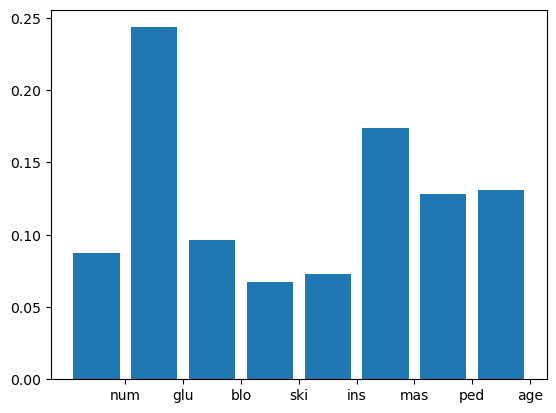

In [53]:
from sklearn.model_selection import train_test_split

# Cargamos datos
fP = 'pimaND.csv'
dfP = pd.read_csv(fP, sep=',')
lVarsTarg = dfP.columns

#
#separación training-test
X_train, X_test, clases_train, clases_test = train_test_split(dfP.values[:,:-1], dfP.values[:,-1], test_size=0.3, random_state=1)

# Lista con los modelos a probar
n_trees = 301
clf= RandomForestClassifier(n_estimators=n_trees)

# Entrenamos
clf.fit(X_train,clases_train)

# Mostramos los atributos más relevantes
_ = plt.bar(np.arange(1,dfP.values.shape[1]), clf.feature_importances_)
_ = plt.xticks(np.arange(1,dfP.values.shape[1])+0.5, [lab[0:3] for lab in lVarsTarg[:-1]])

In [54]:
# see the variables
print(lVarsTarg[:-1])

Index(['numPregnant', 'glucose', 'bloodPress', 'skinThick', 'insulin',
       'massIndex', 'pedigree', 'age'],
      dtype='object')


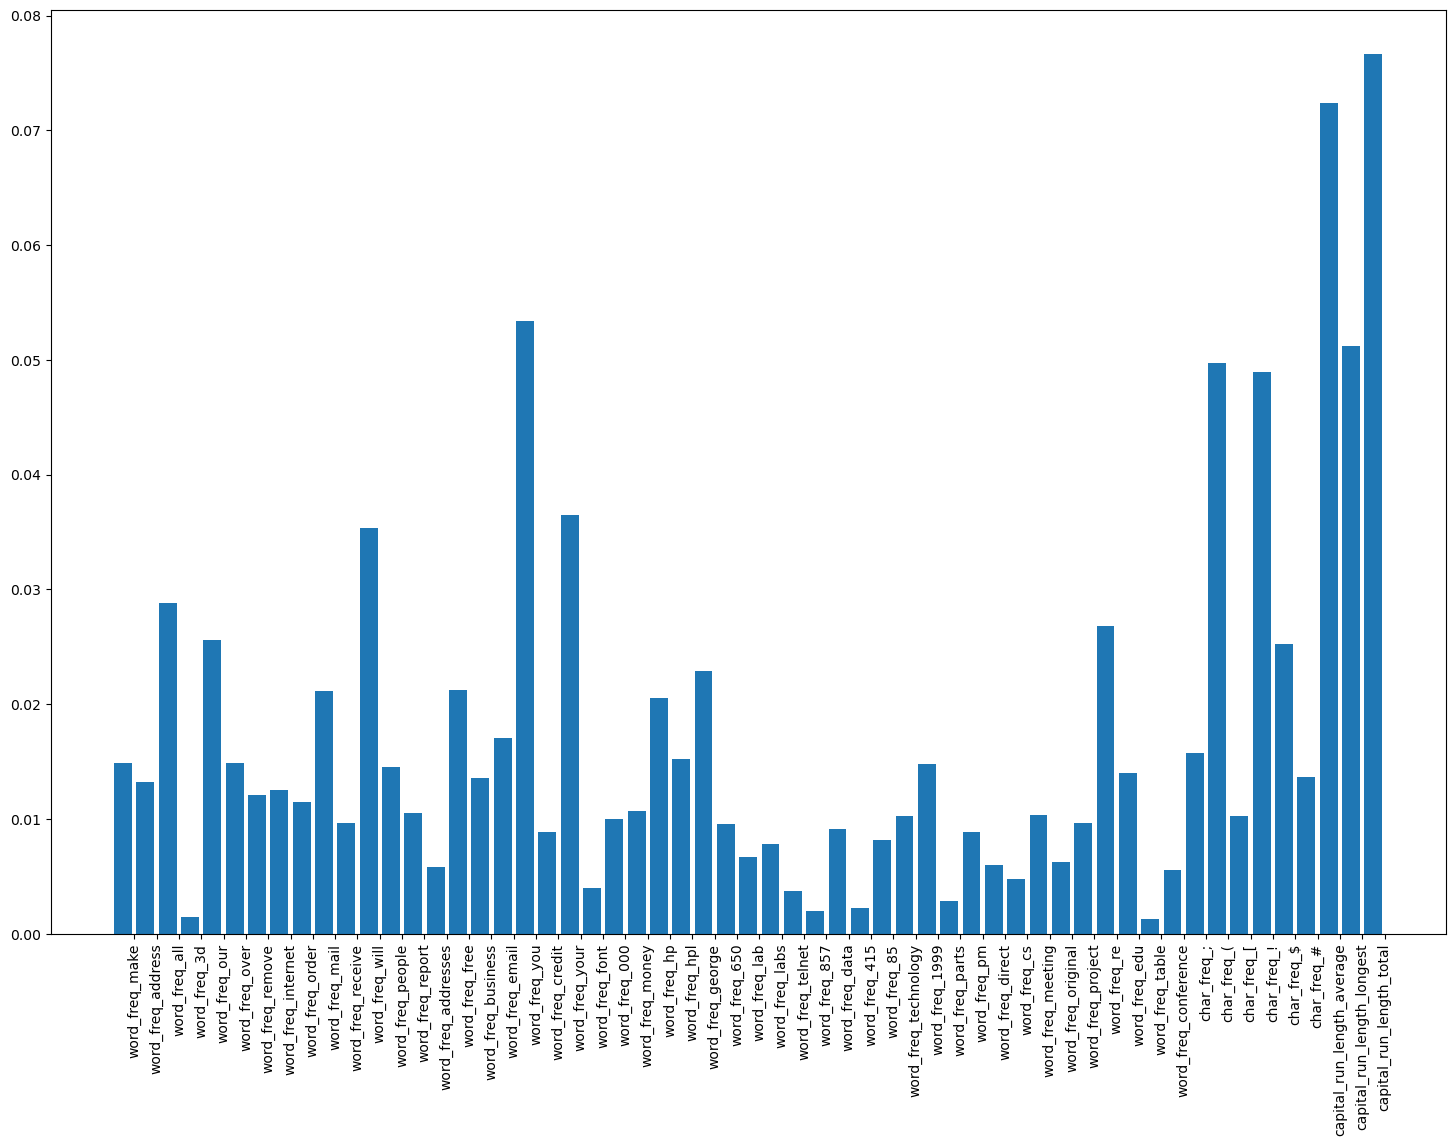

In [55]:
# Cargamos datos
fP = 'spamND.csv'
dfP = pd.read_csv(fP, sep=',')
lVarsTarg = dfP.columns

#
#separación training-test
X_train, X_test, clases_train, clases_test = train_test_split(dfP.values[:,:-1], dfP.values[:,-1], test_size=0.3, random_state=1)

# Lista con los modelos a probar
n_trees = 301
clf= RandomForestClassifier(n_estimators=n_trees)

# Entrenamos
clf.fit(X_train,clases_train)

# Mostramos los atributos más relevantes
plt.figure(figsize=(18,12))
_ = plt.bar(np.arange(1,dfP.values.shape[1]), clf.feature_importances_)
_ = plt.xticks(np.arange(1,dfP.values.shape[1])+0.5, [lab[0:] for lab in lVarsTarg[:-1]], rotation=90)


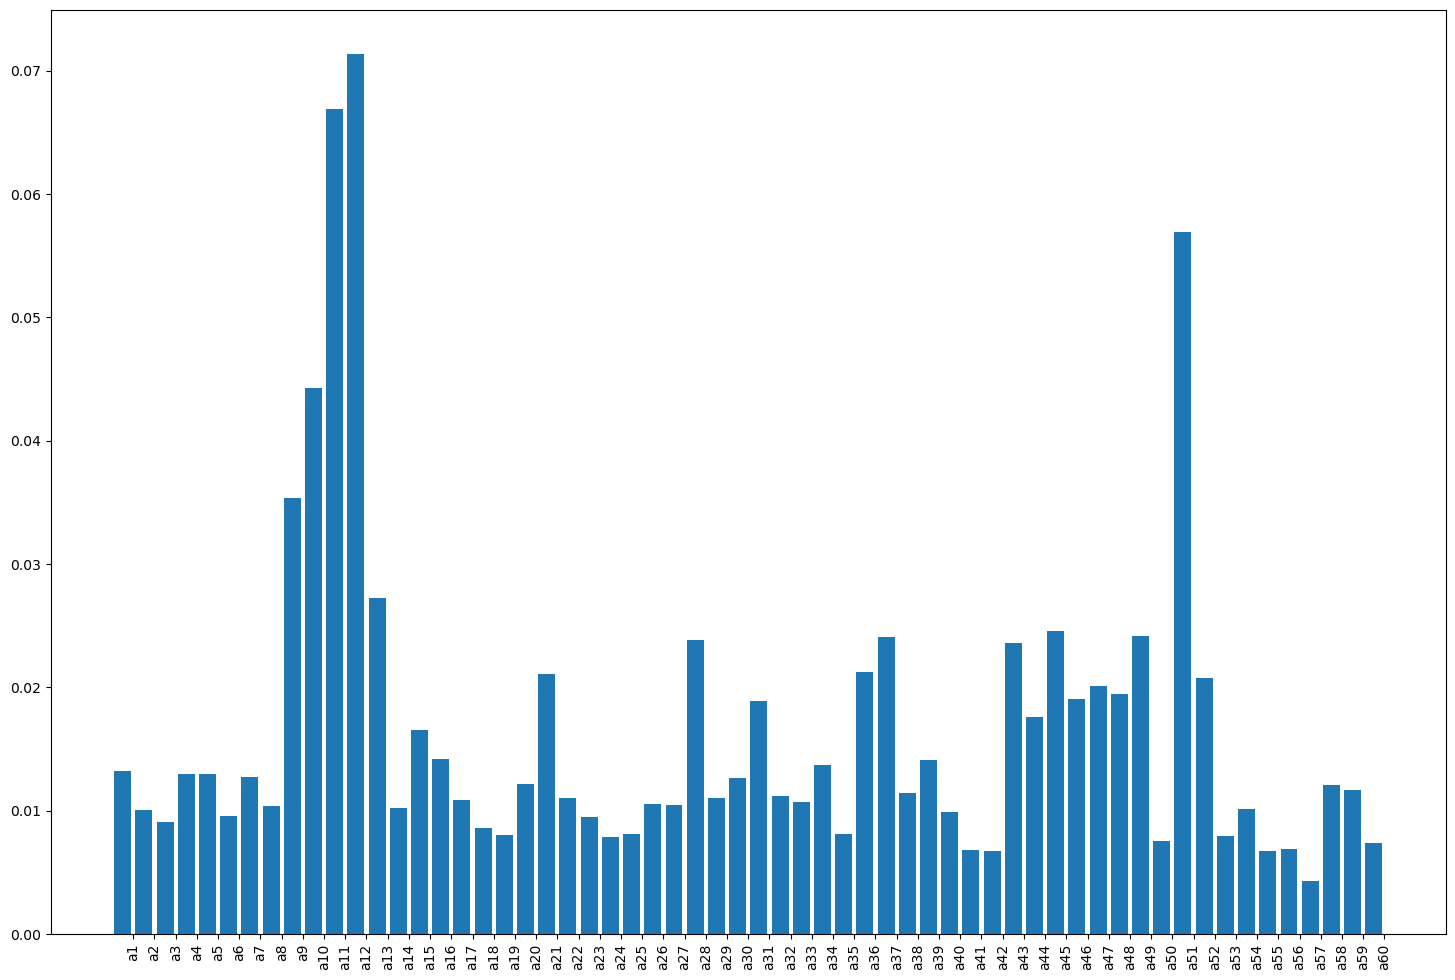

In [56]:
# Cargamos datos
fP = 'sonar.csv'
dfP = pd.read_csv(fP, sep=',')
lVarsTarg = dfP.columns

#
#separación training-test
X_train, X_test, clases_train, clases_test = train_test_split(dfP.values[:,:-1], dfP.values[:,-1], test_size=0.3, random_state=1)

# Lista con los modelos a probar
n_trees = 301
clf= RandomForestClassifier(n_estimators=n_trees)

# Entrenamos
clf.fit(X_train,clases_train)

# Mostramos los atributos más relevantes
plt.figure(figsize=(18,12))
_ = plt.bar(np.arange(1,dfP.values.shape[1]), clf.feature_importances_)
_ = plt.xticks(np.arange(1,dfP.values.shape[1])+0.5, [lab[0:3] for lab in lVarsTarg[:-1]], rotation=90)

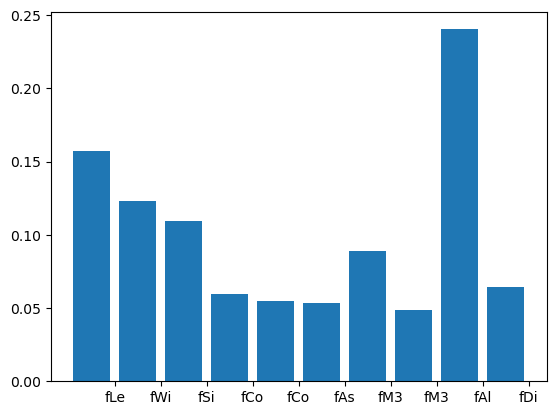

In [58]:
# Cargamos datos
fP = 'magic04.csv'
dfP = pd.read_csv(fP, sep=',')
lVarsTarg = dfP.columns

#
#separación training-test
X_train, X_test, clases_train, clases_test = train_test_split(dfP.values[:,:-1], dfP.values[:,-1], test_size=0.3, random_state=1)

# Lista con los modelos a probar
n_trees = 301
clf= RandomForestClassifier(n_estimators=n_trees)

# Entrenamos
clf.fit(X_train,clases_train)

# Mostramos los atributos más relevantes
_ = plt.bar(np.arange(1,dfP.values.shape[1]), clf.feature_importances_)
_ = plt.xticks(np.arange(1,dfP.values.shape[1])+0.5, [lab[0:3] for lab in lVarsTarg[:-1]])

In [59]:
# see the variables
print(lVarsTarg[:-1])


Index(['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long',
       'fM3Trans', 'fAlpha', 'fDist'],
      dtype='object')


<br/>
<div style="background-color:#EEEEAA;padding:20px;border:solid;"> Indica las dos variables más importante para cada conjunto de datos:

|  Error de test (%) $\pm$ desv   | Nombre Variable 1        | Nombre Variable 2          |
|---------------------------------|--------------------------|----------------------------|
| Pima                            | glucose                  | massIndex                  |
| Spam                            | capital_run_length_total | capital_run_length_average |
| Sonar                           | a12                      | a11                        |
| Magic                           | fAlpha                   | fLength                    |

(+) Rellenar estos datos 
</div>
<br>
<div style="background-color:#AAEEAA;padding:20px;border:solid;">
Comenta los resultados:

**Pima (Predicción de la Diabetes):**
Las características Glucosa y massIndex (Indice de Masa Corporal (BMI:Body Mass Index)) parecen ser las más importantes para predecir la diabetes en este conjunto de datos cuando se utiliza el modelo de Random Forest.

**Spam (Predicción de Spam):**
Las características capital_run_length_total y capital_run_length_average (longitud total y longitud media de las cadenas en mayúsculas del correo) parecen ser las más importantes para predecir correos no deseados (spam) en este conjunto de datos cuando se utiliza el modelo de Random Forest.

**Sonar (Detección de Submarinos):**
Las características a11 y a12 parecen ser las más importantes para predecir la detección de submarinos en este conjunto de datos cuando se utiliza el modelo de Random Forest.

**Magic:**
Las características fAlpha y fLength parecen ser las más importantes para predecir las señales de rayos gamma de alta energía en este conjunto de datos cuando se utiliza el modelo de Bosque Aleatorio.

</div>
<br/>
